# Anomaly Detection using Isolation Forests in SnowparkML

This notebook shows how the Isolation Forest model from the SnowparkML python library can be used to detect anomalies on some sample data. 

The notebook is divided into 3 parts:
1. Sample data generation and upload to SF
2. Model training
3. Saving the model to the Snowpark ML registry

In [4]:
import pandas as pd
import numpy as np
import json
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
from snowflake.ml._internal.utils import identifier
from snowflake.ml.registry import registry
import joblib

In [5]:
# NOTE: Edit the connection.json before creating the session object below
# Create Snowflake Session object
connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/fd21b7ac-6a50-45ae-99ea-568c8161f6d0/saml2?SAMLRequest=nZJNc9owEIb%2Fikc9%2BzN8aoAMBULoUEoCpDO9LfYCamSJamVM8usr7DCTHpJDbx752dWjfbd3e86ld0JDQqs%2Bi4OIeahSnQm177PN%2Bs7vMI8sqAykVthnL0jsdtAjyOWRDwt7UI%2F4p0CynmukiFc%2F%2BqwwimsgQVxBjsRtylfD73OeBBE%2FGm11qiV7V%2FJ5BRChsc7wWpKRcHoHa488DMuyDMqbQJt9mERRFEbd0FEX5MuVP7s3fcDHYdS48I5w%2BPLN7atQ9Qg%2B09rWEPH79XrpL3%2Bs1swbXlVHWlGRo1mhOYkUN4%2FzWoCcAUgrKICCrAEpwEcgG8BrYTAgpcudhGdMdX4srGsfuK9wh1ko9V64CczGfXZ8FtlDDN%2Fao%2B0UTtPoOD39nhR4mPx8nZWQL84kJ8v5%2FmFzelrcd4cp856uESeXiGdEBc7UJVjrjqKk4UeJn7TXScKbXd68Cdrt1i%2FmjV2wQoGtKq%2F2lUeQi9Ro0jurlRQKa8ssibdtSP0WNCO%2F0QT0u10Ev9nqpJ24Fe9aWRRe4k5YvUK8EjGD%2Fx5ML3zf5m0tFy6p2XippUhfvDttcrAfBxkHcXUiMn9XoRxzEHKYZQaJXKBS6nJkEKzbfmsKZO

gio: https://login.microsoftonline.com/fd21b7ac-6a50-45ae-99ea-568c8161f6d0/saml2?SAMLRequest=nZJNc9owEIb%2Fikc9%2BzN8aoAMBULoUEoCpDO9LfYCamSJamVM8usr7DCTHpJDbx752dWjfbd3e86ld0JDQqs%2Bi4OIeahSnQm177PN%2Bs7vMI8sqAykVthnL0jsdtAjyOWRDwt7UI%2F4p0CynmukiFc%2F%2BqwwimsgQVxBjsRtylfD73OeBBE%2FGm11qiV7V%2FJ5BRChsc7wWpKRcHoHa488DMuyDMqbQJt9mERRFEbd0FEX5MuVP7s3fcDHYdS48I5w%2BPLN7atQ9Qg%2B09rWEPH79XrpL3%2Bs1swbXlVHWlGRo1mhOYkUN4%2FzWoCcAUgrKICCrAEpwEcgG8BrYTAgpcudhGdMdX4srGsfuK9wh1ko9V64CczGfXZ8FtlDDN%2Fao%2B0UTtPoOD39nhR4mPx8nZWQL84kJ8v5%2FmFzelrcd4cp856uESeXiGdEBc7UJVjrjqKk4UeJn7TXScKbXd68Cdrt1i%2FmjV2wQoGtKq%2F2lUeQi9Ro0jurlRQKa8ssibdtSP0WNCO%2F0QT0u10Ev9nqpJ24Fe9aWRRe4k5YvUK8EjGD%2Fx5ML3zf5m0tFy6p2XippUhfvDttcrAfBxkHcXUiMn9XoRxzEHKYZQaJXKBS6nJkEKzbfmsKZOGgvvXf%2FR%2F8BQ%3D%3D&RelayState=36347: Operation not supported



Connection Established with the following parameters:
User                        : WALEED_ALI
Role                        : "SYSADMIN"
Database                    : "DEV_ML_WALEED"
Schema                      : "RAW"
Warehouse                   : "DEV"
Snowflake version           : 8.8.2
Snowpark for Python version : 1.11.1


## 1. Sample Data Generation

Create a toy dataset with some noise to detect anomalous values. 

In [9]:
RANDOM_STATE = 2024
def sample_ts_data(start, end, freq='H', outlier_frac=0.05, random_state=2024):
    """
    this functions returns a dataframe with three columns: EVENT_TIME, EVENT_VALUE and IS_ANOMALY

    Parameters:
    ------------------
    start: datetime for the start of EVENT_TIME
    end: datetime for the end of EVENT_TIME
    freq: frequency of EVENT_TIME
    outlier_frac: proportion of the data to add as noise
    """
    RANDOM_STATE = random_state

    date_range = pd.date_range(start=start, end=end, freq=freq)

    # Create some fake data
    data = np.random.normal(loc=10, scale=1, size=len(date_range))

    # Create a dataframe and add fake data
    col = 'event_value'
    df = pd.DataFrame(index=[d.to_pydatetime() for d in date_range], columns=[col])
    df[col] = data

    
    # add some anomalies to the data
    n_outliers = int(len(date_range) * outlier_frac)
    # print(n_outliers)

    out_idx = df.sample(n_outliers, random_state=RANDOM_STATE).index

    outliers = np.random.normal(loc=20, scale=2, size=n_outliers)

    df.loc[out_idx, col] = outliers

    # using isolation forest notation of 1 for inliers, -1 for outliers
    df['is_anomaly'] = 1
    df.loc[out_idx, 'is_anomaly'] = -1

    df = df.reset_index().rename(columns={'index': 'event_time'})

    df.columns = [col.upper() for col in df.columns]
    return df

In [92]:
s = '2024-02-08 00:00:00'
e = '2024-02-13 00:00:00'

df = sample_ts_data(s,e)

In [94]:
df.head(5)

,EVENT_TIME,EVENT_VALUE,IS_ANOMALY
0,2024-02-08 00:00:00,9.831890,1
1,2024-02-08 01:00:00,10.744412,1
2,2024-02-08 02:00:00,9.754194,1
3,2024-02-08 03:00:00,9.678135,1
4,2024-02-08 04:00:00,11.138309,1


In [95]:
df.query("IS_ANOMALY == -1")['EVENT_VALUE']

17     20.828356
32     17.641362
50     19.729686
85     20.358684
101    20.354552
116    18.406266
Name: EVENT_VALUE, dtype: float64

In [96]:
et = 'EVENT_TIME'
ev = 'EVENT_VALUE'

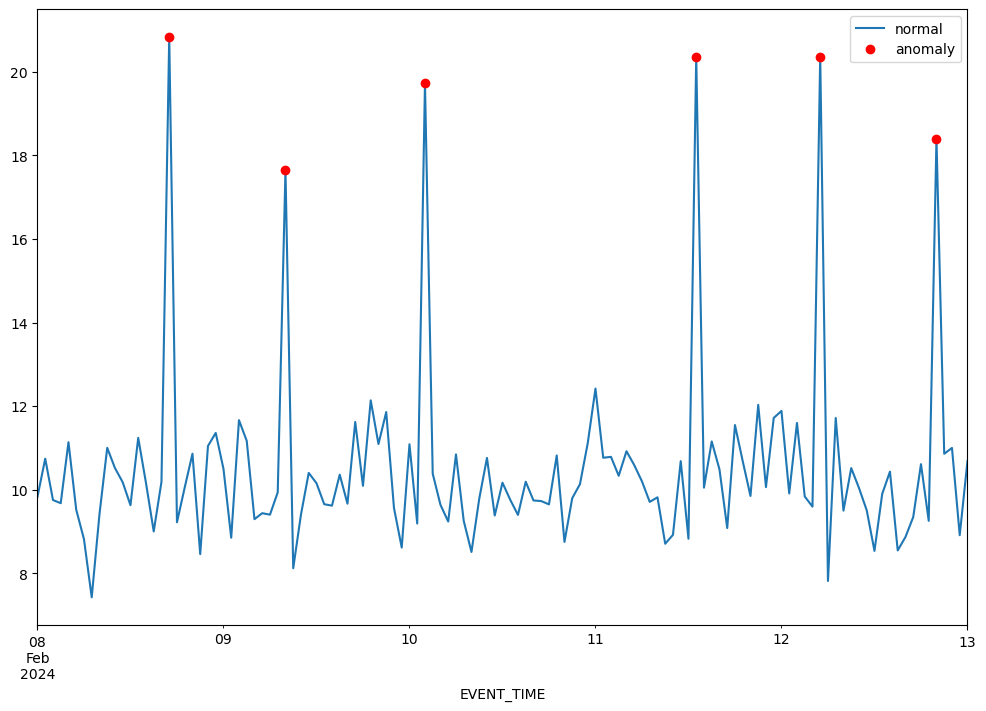

In [97]:
# Visualise data
ax = df.plot(figsize=(12,8), label='normal', y=ev, x=et)
df.query("IS_ANOMALY == -1").plot(ax=ax, label='anomaly',y=ev, x=et, color='red', marker='o', ls='')
ax.legend()

### 1.2 Upload data to a Snowflake table

In [98]:
TABLE_NAME = 'TIMESERIES'
session.write_pandas(df, TABLE_NAME, auto_create_table=True, overwrite=True, use_logical_type=True)

ERROR:snowflake.connector.ocsp_snowflake:WARNING!!! Using fail-open to connect. Driver is connecting to an HTTPS endpoint without OCSP based Certificate Revocation checking as it could not obtain a valid OCSP Response to use from the CA OCSP responder. Details: 
 {'driver': 'PythonConnector', 'version': '3.7.0', 'eventType': 'RevocationCheckFailure', 'eventSubType': 'OCSPResponseExpired', 'sfcPeerHost': 'kfrmojsfcb1stg.blob.core.windows.net', 'certId': 'MEowBwYFKw4DAhoEFFIe42xHgRmpywP6t05X4Rl68YGLBBS1dgwwEc7HkkJNTMdcLMipDOgLZAITSwAzDOXP8IzvnAOYPQAAADMM5Q==', 'ocspRequestBase64': 'MFIwUDBOMEwwSjAHBgUrDgMCGgQUUh7jbEeBGanLA/q3TlfhGXrxgYsEFLV2DDARzseSQk1Mx1wsyKkM6AtkAhNLADMM5c/wjO+cA5g9AAAAMwzl', 'ocspResponderURL': 'http://ocsp.msocsp.com', 'errorMessage': '254013: Response is unreliable. Its validity date is out of range: current_time=2024-02-26 18:10:24Z, this_update=2024-02-27 06:20:18Z, next_update=2024-03-02 06:20:17Z, tolerable next_update=2024-03-02 07:17:52Z. A potential cause is 

In [17]:
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{TABLE_NAME}"
print(input_tbl)

"DEV_ML_WALEED"."RAW".TIMESERIES


In [18]:
# Read in the data from a Snowflake table into a Snowpark DataFrame
df = session.table(input_tbl)

In [19]:
df.show()

-----------------------------------------------------------
|"EVENT_TIME"         |"EVENT_VALUE"       |"IS_ANOMALY"  |
-----------------------------------------------------------
|2024-02-08 00:00:00  |10.665875842123747  |1             |
|2024-02-08 01:00:00  |10.04333664489181   |1             |
|2024-02-08 02:00:00  |9.792750232887302   |1             |
|2024-02-08 03:00:00  |9.188637077009224   |1             |
|2024-02-08 04:00:00  |8.558264829355837   |1             |
|2024-02-08 05:00:00  |9.50455333572502    |1             |
|2024-02-08 06:00:00  |9.237881538604768   |1             |
|2024-02-08 07:00:00  |8.996089245800553   |1             |
|2024-02-08 08:00:00  |11.054248843210978  |1             |
|2024-02-08 09:00:00  |8.174132317111203   |1             |
-----------------------------------------------------------



In [20]:
type(df)

snowflake.snowpark.table.Table

In [21]:
print(df.schema)

StructType([StructField('EVENT_TIME', TimestampType(tz=ntz), nullable=True), StructField('EVENT_VALUE', DoubleType(), nullable=True), StructField('IS_ANOMALY', LongType(), nullable=True)])


## 2. Model Training

In [22]:
from snowflake.ml.modeling.preprocessing import StandardScaler
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.ensemble import IsolationForest
from snowflake.snowpark.functions import col
from snowflake.ml.modeling.metrics import accuracy_score, confusion_matrix

### 2.1 Pre-processing 
Scale the data as part of data processing

In [23]:
input_col = 'EVENT_VALUE'
output_col = 'X_SCALED'

preprocessing_pipeline = Pipeline(
    steps=[
            (
                "OE",
                StandardScaler(
                    input_cols=input_col,
                    output_cols=output_col,
                    passthrough_cols = ['EVENT_TIME', 'IS_ANOMALY']
                )
            ),
    ]
)

In [115]:
PIPELINE_FILE = 'preprocessing_pipeline.joblib'
joblib.dump(preprocessing_pipeline, PIPELINE_FILE) # We are just pickling it locally first
# Save pipeline in the stage created during the setup step in snowflake
session.file.put(PIPELINE_FILE, "@ML_ASSETS", overwrite=True)

ERROR:snowflake.connector.ocsp_snowflake:WARNING!!! Using fail-open to connect. Driver is connecting to an HTTPS endpoint without OCSP based Certificate Revocation checking as it could not obtain a valid OCSP Response to use from the CA OCSP responder. Details: 
 {'driver': 'PythonConnector', 'version': '3.7.0', 'eventType': 'RevocationCheckFailure', 'eventSubType': 'OCSPResponseExpired', 'sfcPeerHost': 'kfrmojsfcb1stg.blob.core.windows.net', 'certId': 'MEowBwYFKw4DAhoEFFIe42xHgRmpywP6t05X4Rl68YGLBBS1dgwwEc7HkkJNTMdcLMipDOgLZAITSwAzDOXP8IzvnAOYPQAAADMM5Q==', 'ocspRequestBase64': 'MFIwUDBOMEwwSjAHBgUrDgMCGgQUUh7jbEeBGanLA/q3TlfhGXrxgYsEFLV2DDARzseSQk1Mx1wsyKkM6AtkAhNLADMM5c/wjO+cA5g9AAAAMwzl', 'ocspResponderURL': 'http://ocsp.msocsp.com', 'errorMessage': '254013: Response is unreliable. Its validity date is out of range: current_time=2024-02-26 19:05:36Z, this_update=2024-02-27 06:20:18Z, next_update=2024-03-02 06:20:17Z, tolerable next_update=2024-03-02 07:17:52Z. A potential cause is 

[PutResult(source='preprocessing_pipeline.joblib', target='preprocessing_pipeline.joblib.gz', source_size=1368, target_size=960, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

In [24]:
# Split the data into train and test sets
# TODO: use stratified sampling (not available in snowparkML)
train_df, test_df = df.select(col(input_col), col("IS_ANOMALY")).random_split(weights=[0.9, 0.1], seed=2024) 

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.fit(train_df).transform(train_df)
test_df = preprocessing_pipeline.transform(test_df)

In [25]:
train_df.show()

------------------------------------------------------------
|"X_SCALED"            |"EVENT_VALUE"       |"IS_ANOMALY"  |
------------------------------------------------------------
|0.06689493914320281   |10.665875842123747  |1             |
|-0.17168540898136472  |10.04333664489181   |1             |
|-0.2677195120180089   |9.792750232887302   |1             |
|-0.4992383106364439   |9.188637077009224   |1             |
|-0.3781673623045835   |9.50455333572502    |1             |
|-0.4803659876680083   |9.237881538604768   |1             |
|-0.5730298546944805   |8.996089245800553   |1             |
|0.21573402624578306   |11.054248843210978  |1             |
|-0.8880345500808242   |8.174132317111203   |1             |
|-0.3280449390575307   |9.635340189616473   |1             |
------------------------------------------------------------



In [26]:
test_df.show()

------------------------------------------------------------
|"X_SCALED"            |"EVENT_VALUE"       |"IS_ANOMALY"  |
------------------------------------------------------------
|-0.740820577202029    |8.558264829355837   |1             |
|-0.3845151141792127   |9.48798984092202    |1             |
|-0.1030303381221727   |10.222481629105964  |1             |
|0.21878823895195493   |11.062218347578048  |1             |
|-0.44518223684574454  |9.32968819478864    |1             |
|-0.7018289941958422   |8.66000744551968    |1             |
|0.05224736957394741   |10.62765523312253   |1             |
|-0.16392989829709662  |10.063573472583029  |1             |
|0.12798654629710668   |10.825285116081814  |1             |
|-0.19552817495454278  |9.981122566886603   |1             |
------------------------------------------------------------



### 2.2 Model Building

In [27]:
model = IsolationForest(input_cols=output_col, output_cols='PRED_IS_ANOMALY', contamination=0.05)

model.fit(train_df)

# result = model.predict(test_df)

The version of package 'xgboost' in the local environment is 1.7.6, which does not fit the criteria for the requirement 'xgboost==1.7.3'. Your UDF might not work when the package version is different between the server and your local environment.


In [28]:
result = model.predict(test_df)
result.show()

--------------------------------------------------------------------------------
|"X_SCALED"            |"EVENT_VALUE"       |"IS_ANOMALY"  |"PRED_IS_ANOMALY"  |
--------------------------------------------------------------------------------
|-0.740820577202029    |8.558264829355837   |1             |1                  |
|-0.3845151141792127   |9.48798984092202    |1             |1                  |
|-0.1030303381221727   |10.222481629105964  |1             |1                  |
|0.21878823895195493   |11.062218347578048  |1             |1                  |
|-0.44518223684574454  |9.32968819478864    |1             |1                  |
|-0.7018289941958422   |8.66000744551968    |1             |1                  |
|0.05224736957394741   |10.62765523312253   |1             |1                  |
|-0.16392989829709662  |10.063573472583029  |1             |1                  |
|0.12798654629710668   |10.825285116081814  |1             |1                  |
|-0.19552817495454278  |9.98

In [34]:
acc = accuracy_score(df=result, y_true_col_names='IS_ANOMALY', y_pred_col_names='PRED_IS_ANOMALY')
print(f"Accuracy = {acc*100:.1f}%")

Accuracy = 90.9%


In [41]:
identifier._get_unescaped_name(session.get_current_database())

'DEV_ML_WALEED'

## 3. Save model to registry

In [43]:
# Save model 
# Get sample input data to pass into the registry logging function
X = train_df.limit(100)

db = identifier._get_unescaped_name(session.get_current_database())
schema = identifier._get_unescaped_name(session.get_current_schema())

# Define model name
model_name = "ANOMALY_DETECTION_ISOLATION_FOREST"

# Create a registry and log the model
native_registry = registry.Registry(session=session, database_name=db, schema_name=schema)

# Let's first log the very first model we trained
model_ver = native_registry.log_model(
    model_name=model_name,
    version_name='V0',
    model=model,
    sample_input_data=X, # to provide the feature schema
)

# Add evaluation metric
model_ver.set_metric(metric_name="accuracy", value=acc)

# Add a description
model_ver.comment = "This is the first iteration of our Anomaly Detection model using Isolation Forests. It is used for demo purposes."


/home/aliw/miniconda3/envs/snowpark-ml-dq/lib/python3.11/site-packages/snowflake/ml/model/_packager/model_packager.py:91: UserWarning: Inferring model signature from sample input or providing model signature for Snowpark ML Modeling model is not required. Model signature will automatically be inferred during fitting. 
  handler.save_model(
ERROR:snowflake.connector.ocsp_snowflake:WARNING!!! Using fail-open to connect. Driver is connecting to an HTTPS endpoint without OCSP based Certificate Revocation checking as it could not obtain a valid OCSP Response to use from the CA OCSP responder. Details: 
 {'driver': 'PythonConnector', 'version': '3.7.0', 'eventType': 'RevocationCheckFailure', 'eventSubType': 'OCSPResponseExpired', 'sfcPeerHost': 'kfrmojsfcb1stg.blob.core.windows.net', 'certId': 'MEowBwYFKw4DAhoEFFIe42xHgRmpywP6t05X4Rl68YGLBBS1dgwwEc7HkkJNTMdcLMipDOgLZAITSwAzDOXP8IzvnAOYPQAAADMM5Q==', 'ocspRequestBase64': 'MFIwUDBOMEwwSjAHBgUrDgMCGgQUUh7jbEeBGanLA/q3TlfhGXrxgYsEFLV2DDARzseSQk1

In [44]:
# Let's confirm they were added
native_registry.get_model(model_name).show_versions()

,created_on,name,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-02-27 16:17:05.497000+11:00,V0,This is the first iteration of our Anomaly Det...,DEV_ML_WALEED,RAW,ANOMALY_DETECTION_ISOLATION_FOREST,true,"[""PREDICT"",""DECISION_FUNCTION""]","{""metrics"": {""accuracy"": 0.909091}, ""snowpark_...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."


In [47]:
# test running model on data
model_ver = native_registry.get_model(model_name).version('v0')
result_sdf2 = model_ver.run(test_df, function_name="predict")
result_sdf2.show()

--------------------------------------------------------------------------------
|"EVENT_VALUE"       |"IS_ANOMALY"  |"X_SCALED"            |"PRED_IS_ANOMALY"  |
--------------------------------------------------------------------------------
|8.558264829355837   |1             |-0.740820577202029    |1                  |
|9.48798984092202    |1             |-0.3845151141792127   |1                  |
|10.222481629105964  |1             |-0.1030303381221727   |1                  |
|11.062218347578048  |1             |0.21878823895195493   |1                  |
|9.32968819478864    |1             |-0.44518223684574454  |1                  |
|8.66000744551968    |1             |-0.7018289941958422   |1                  |
|10.62765523312253   |1             |0.05224736957394741   |1                  |
|10.063573472583029  |1             |-0.16392989829709662  |1                  |
|10.825285116081814  |1             |0.12798654629710668   |1                  |
|9.981122566886603   |1     